# Multi-class Classification and Neural Networks

In [1]:
import os

import numpy as np

from matplotlib import pyplot as plt

from scipy import optimize
from scipy.io import loadmat

%matplotlib inline

## Load data


In [2]:
input_layer_size = 400

num_labels = 10

data = loadmat(os.path.join('Data', 'ex3data1.mat'))
X,y = data['X'], data['y'].ravel()

# set the zero digit to 0, rather than its mapped 10 in this dataset
# This is an artifact due to the fact that this dataset was used in 
# MATLAB where there is no index 0
y[y==10] = 0

m = y.size

## Visualising data

In [3]:
rand_indices = np.random.choice(m, 100, replace = False)
sel = X[rand_indices, :]

In [6]:
def displayData(X, example_width=None, figsize=(10, 10)):
    """
    Displays 2D data stored in X in a nice grid.
    """
    # Compute rows, cols
    if X.ndim == 2:
        m, n = X.shape
    elif X.ndim == 1:
        n = X.size
        m = 1
        X = X[None]  # Promote to a 2 dimensional array
    else:
        raise IndexError('Input X should be 1 or 2 dimensional.')

    example_width = example_width or int(np.round(np.sqrt(n)))
    example_height = n / example_width

    # Compute number of items to display
    display_rows = int(np.floor(np.sqrt(m)))
    display_cols = int(np.ceil(m / display_rows))

    fig, ax_array = plt.subplots(display_rows, display_cols, figsize=figsize)
    fig.subplots_adjust(wspace=0.025, hspace=0.025)

    ax_array = [ax_array] if m == 1 else ax_array.ravel()

    for i, ax in enumerate(ax_array):
        ax.imshow(X[i].reshape(example_width, example_width, order='F'),
                  cmap='Greys', extent=[0, 1, 0, 1])
        ax.axis('off')


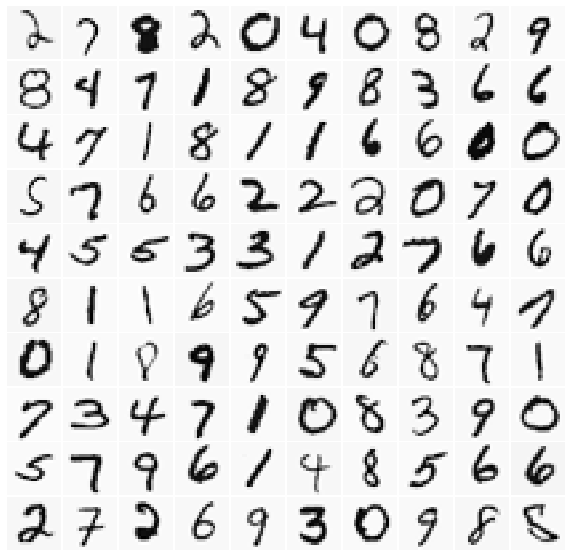

In [7]:
displayData(sel)

## Vectorising using Logistic Regression

In [8]:
# test values for the parameters theta
theta_t = np.array([-2, -1, 1, 2], dtype=float)

# test values for the inputs
X_t = np.concatenate([np.ones((5, 1)), np.arange(1, 16).reshape(5, 3, order='F')/10.0], axis=1)

# test values for the labels
y_t = np.array([1, 0, 1, 0, 1])

# test value for the regularization parameter
lambda_t = 3

## Cost Function

In [11]:
def sigmoid(z):
    
    return 1.0 / (1.0 + np.exp(-z))


In [12]:
def lrCostFunction(theta,X,y, lambda_):
    
    m = y.size
    
    if y.dtype == bool:
        y = y.astype(int)
        
    J= 0
    grad = np.zeros(theta.shape)
    
    h = sigmoid(np.dot(X,theta.T))
    
    temp = theta
    temp[0] = 0
    
    J = 1/m*(-y.dot(np.log(h)) - (1-y).dot(np.log(1-h))) + (lambda_/(2*m))*np.sum(np.square(temp))
    
    grad = (1/m)*(h-y).dot(X) + (lambda_/m)*temp
    
    
    return J, grad
    

In [13]:
J, grad = lrCostFunction(theta_t, X_t, y_t, lambda_t)

print('Cost         : {:.6f}'.format(J))
print('Expected cost: 2.534819')
print('-----------------------')
print('Gradients:')
print(' [{:.6f}, {:.6f}, {:.6f}, {:.6f}]'.format(*grad))
print('Expected gradients:')
print(' [0.146561, -0.548558, 0.724722, 1.398003]');

Cost         : 2.534819
Expected cost: 2.534819
-----------------------
Gradients:
 [0.146561, -0.548558, 0.724722, 1.398003]
Expected gradients:
 [0.146561, -0.548558, 0.724722, 1.398003]


## One-vs-all Classification

In [17]:
def oneVsAll(X,y, num_labels, lambda_):
    
    m, n = X.shape
    
    all_theta = np.zeros((num_labels, n+1))
    
    X = np.concatenate([np.ones((m,1)), X], axis = 1)
    
    for c in np.arange(num_labels):
        initial_theta = np.zeros(n+1)
        options = {'maxiter': 50}
        res = optimize.minimize(lrCostFunction, 
                                initial_theta, 
                                (X, (y == c), lambda_), 
                                jac=True, 
                                method='CG',
                                options=options) 
        
        all_theta[c] = res.x
        
    return all_theta

In [18]:
lambda_ = 0.1
all_theta = oneVsAll(X,y, num_labels, lambda_)

## One-vs-All Prediction

In [20]:
def predictOneVsAll(all_theta, X):
    m = X.shape[0]
    
    num_labels = all_theta.shape[0]
    
    p = np.zeros(m)
    
    X = np.concatenate([np.ones((m,1)), X], axis= 1)
    
    p = np.argmax(sigmoid(X.dot(all_theta.T)), axis = 1)
    
    return p

In [22]:
pred = predictOneVsAll(all_theta, X)
print('Training Set Accuracy: {:.2f}%'.format(np.mean(pred == y) * 100))

Training Set Accuracy: 95.18%


# Neural network

## Load data

In [23]:
data = loadmat(os.path.join('Data','ex3data1.mat'))
X,y = data['X'], data['y'].ravel()

y[y==10] = 0

m = y.size

indices = np.random.permutation(m)

rand_indices = np.random.choice(m,100, replace = False)
sel = X[rand_indices, :]


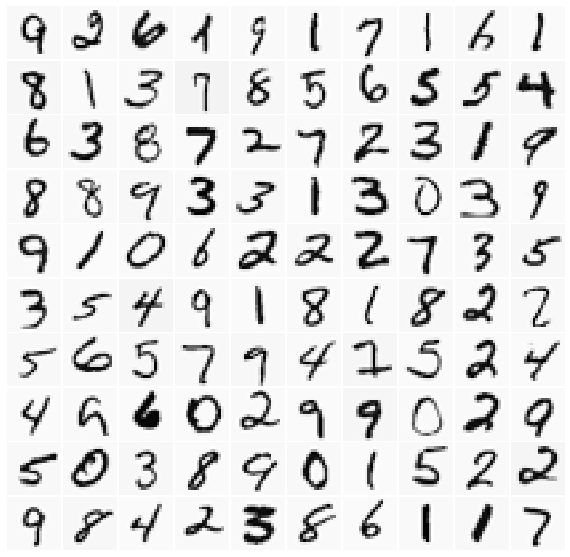

In [25]:
displayData(sel)

## Model Representation

In [26]:
input_layer_size = 400
hidden_layer_size = 25
num_labels = 10

# already trained weights are given in the data
weights = loadmat(os.path.join('Data','ex3weights.mat'))

Theta1, Theta2 = weights['Theta1'], weights['Theta2']

Theta2 = np.roll(Theta2, 1, axis = 0)

In [27]:
Theta1.shape

(25, 401)

## Forward Propagation

In [30]:
def predict(Theta1, Theta2, X):
    if X.ndim == 1:
        X = X[None]
        
    m = X.shape[0]
    num_labels = Theta2.shape[0]
    
    p = np.zeros(X.shape[0])
    
    X = np.concatenate([np.ones((m,1)), X], axis = 1)
    
    a2 = sigmoid(np.dot(X, Theta1.T))
    a2 = np.concatenate([np.ones((a2.shape[0],1)), a2], axis = 1)
    
    p = np.argmax(sigmoid(a2.dot(Theta2.T)), axis = 1)
    return p

In [31]:
pred = predict(Theta1, Theta2, X)
print('Training Set Accuracy: {:.1f}%'.format(np.mean(pred == y) * 100))

Training Set Accuracy: 97.5%


## Displaying Result

Neural Network Prediction: 2


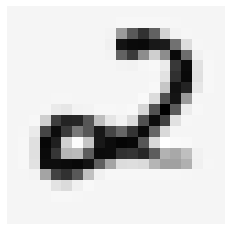

In [43]:
if indices.size > 0:
    i, indices = indices[0], indices[1:]
    displayData(X[i, :], figsize=(4, 4))
    pred = predict(Theta1, Theta2, X[i, :])
    print('Neural Network Prediction: {}'.format(*pred))
else:
    print('No more images to display!')